## Part 1 Exploration

Define data and model. **For a live version of this notebook visit [this link](https://colab.research.google.com/drive/1JByKkFNL2AG2IztMCvCYev2JVqFrOoST?usp=sharing).**

In [26]:
import numpy as np
from scipy.optimize import fmin
import matplotlib.pyplot as plt

y = np.array([
    0.3573, 0.3618, 0.1920, 0.1585, 0.1041, 0.1100, 0.0560, 0.0291, 0.0252, 0.0249, 0.04160
]).reshape(-1, 1)
t = np.linspace(0, 1, len(y)).reshape(-1,1)
sigma = 0.02
theta_ground = np.array([.4,3]).reshape(-1,1)

def model(t, theta):
    a,b = theta
    return a * np.exp(-b * t)

print(y)
print(t)

[[0.3573]
 [0.3618]
 [0.192 ]
 [0.1585]
 [0.1041]
 [0.11  ]
 [0.056 ]
 [0.0291]
 [0.0252]
 [0.0249]
 [0.0416]]
[[0. ]
 [0.1]
 [0.2]
 [0.3]
 [0.4]
 [0.5]
 [0.6]
 [0.7]
 [0.8]
 [0.9]
 [1. ]]


See current predictions from given model

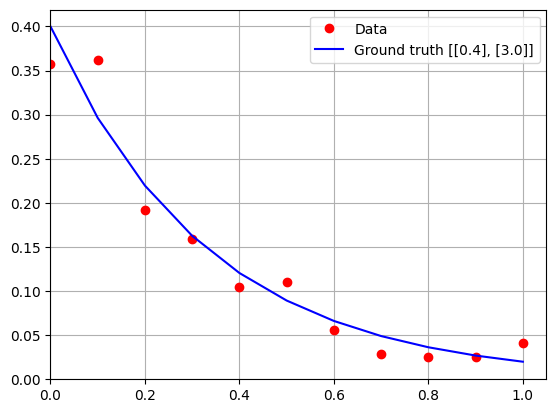

In [27]:
y_pred = model(t,theta_ground)
plt.plot(t, y, 'ro', label='Data')
plt.plot(t, y_pred, 'b-', label=f'Ground truth {theta_ground.tolist()}')
plt.legend()
plt.xlim([0,None])
plt.ylim([0,None])
plt.grid(True)
plt.show()

## 1. Likelihood density

Likelihood function for theta, given y, 

$$
L(\theta | y) = P(y | \theta)
    \\ = \prod_{i=0}^{m} P(y^{(i)} | \theta)
    \\ = \prod_{i=0}^{m} \frac{1}{\sqrt{(2\pi)^p | \Sigma |} } \exp( - \frac{1}{2} ( y^{(i)} - a e^{(-b t^{(i)})} )^T \Sigma^{-1} ( y^{(i)} - a e^{(-b t^{(i)})} ) )
$$
$$
    \\ = \frac{1}{\sqrt{(2\pi)^m|\sigma^2 I|}} \exp( -\frac{1}{2}  \frac{ \sum_{i=1}^{m}{  ( y^{(i)} - a e^{(-b t^{(i)})} )^2  } } {\sigma^2}  )
$$


Where $p = 1$ is dimension of each observation $y$, $m = 11$ is the number of data points  and covariance matrix $\Sigma = \sigma I$, where $I$ is identity matrix.

We derive negative log-likelihood:

$$
    -\log(L(\theta | y))
    \\ = -\log( \frac{1}{\sqrt{(2\pi)^m|\sigma^2 I|}} \exp( -\frac{1}{2}  \frac{ \sum_{i=1}^{m}{  ( y^{(i)} - a e^{(-b t^{(i)})} )^2  } } {\sigma^2}  ) )
$$
$$
    \\ = \log(\sqrt{(2\pi)^m|\sigma^2 I|} ) + \frac{1}{2}  \frac{1}{ {\sigma^2} } \sum_{i=1}^{m}{  ( y^{(i)} - a e^{(-b t^{(i)})} )^2  }
    \\ = m/2\log({2\pi}) - 2m\log(\sigma) - \frac{1}{2\sigma^2} \sum_{i=1}^{m}{  ( y^{(i)} - a e^{(-b t^{(i)})} )^2  }
$$

Random uniform theta [[1.3745401188473625], [1.9507143064099162]]
Ground truth theta [[0.4], [3.0]]
NLL for random values 4117.091455482835
NLL for ground truth model (make sure it is smaller!) -75.21683020994485
Optimization terminated successfully.
         Current function value: -75.371518
         Iterations: 33
         Function evaluations: 64
Theta found through optimization [0.39111001225468145, 2.959941328713283]


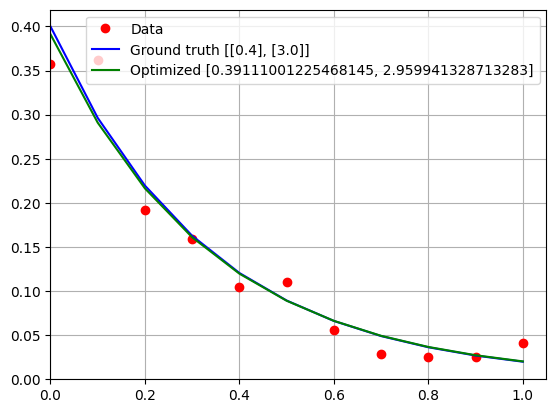

In [58]:
np.random.seed(42)

def nll(theta, t, y, sigma):
    m = y.shape[0]
    p = theta.shape[0]
    return  2 * m * np.log(sigma) \
        + 1/(2 * sigma**2) * sum((y - model(t, theta))**2)


theta = np.random.uniform(1,2,size=(2,1))

print("Random uniform theta", theta.tolist())
print("Ground truth theta", theta_ground.tolist())
print("NLL for random values", nll(theta, t, y, sigma).item())
print(f"NLL for ground truth model (make sure it is smaller!)", nll(theta_ground, t, y, sigma).item())

theta_optimized = fmin(nll, x0=theta, args=(t, y, sigma), xtol=.05)

print(f"Theta found through optimization {theta_optimized.tolist()}")


y_pred = model(t,theta_ground)
y_opt = model(t,theta_optimized)
plt.plot(t, y, 'ro', label='Data')
plt.plot(t, y_pred, 'b-', label=f'Ground truth {theta_ground.tolist()}')
plt.plot(t, y_opt, 'g-', label=f'Optimized {theta_optimized.tolist()}')
plt.legend()
plt.xlim([0,None])
plt.ylim([0,None])
plt.grid(True)
plt.show()

## Conditional Expectation

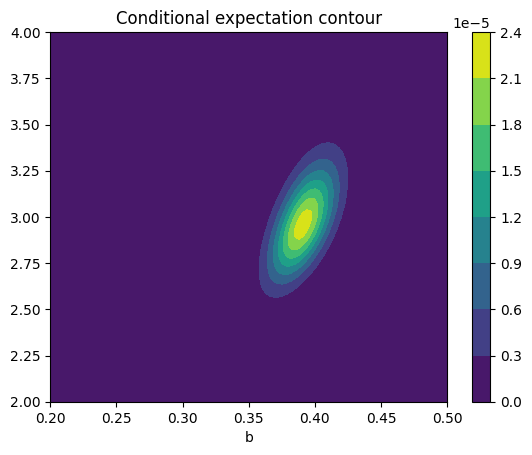

In [158]:
def pfun(a,b,t,y):
    N = y.shape[0]
    
    # To avoid explosion in exponent, we clip exponent
    model = a * np.clip(np.exp(-b * t), 0, 1e32)
    diff = y - model
    inv_C = np.eye(N) / (sigma**2)
    integ_f = np.exp( - .5 * diff.T @ inv_C @ diff )
    return integ_f

xx,yy = np.meshgrid(np.linspace(0.2,.5, num=100),np.linspace(2,4,100))
zz = []
for a,b in zip(xx.ravel(), yy.ravel()):
    zz.append( pfun(a,b,t,y) )
zz = np.array(zz).reshape(*xx.shape)

plt.title("Conditional expectation contour")
plt.contourf(xx,yy,zz)
# plt.axis("equal")
plt.xlabel("a")
plt.xlabel("b")
plt.colorbar()
plt.show()

In [159]:
from scipy.integrate import dblquad

integral_f = lambda a,b: float(pfun(a,b,t,y))
evidence, _ = dblquad(integral_f,  -np.inf, np.inf,  -np.inf, np.inf)

print("Evidence", evidence)

/tmp/ipykernel_12552/907457587.py:7: RuntimeWarning: overflow encountered in exp
  model = a * np.clip(np.exp(-b * t), 0, 1e32)


Evidence 2.591101807697243e-07


In [160]:
# scipy.integrate.dblquad has to have the signature 
# func(y, x) -> scalar
cm_a = lambda a,b: float(a * integral_f(a,b) / evidence )
cm_b = lambda a,b: float(b * integral_f(a,b) / evidence )


# This somehow always fails. It is possible the cm function is too large or too small?
cm_pairs = [
    dblquad(cm_a, -np.inf, np.inf, -np.inf, np.inf)[0],
    dblquad(cm_b, -np.inf, np.inf, -np.inf, np.inf)[0],
]
print(f"p(a)={cm_pairs[0]}\n p(b)={cm_pairs[1]}")

/tmp/ipykernel_12552/907457587.py:7: RuntimeWarning: overflow encountered in exp
  model = a * np.clip(np.exp(-b * t), 0, 1e32)


p(a)=0.5990761690328219
 p(b)=4.561546774485372


# Priors

Let's define gaussian prior to be

$$
    P(\theta)=(2\pi)^{-1}|\Sigma|^{-1/2}\exp(-1/2(\theta-\mu)^T\Sigma^{-1}(\theta-\mu))
$$

Where $\mu=(0.4,3.0)^T$ and $\Sigma=\sigma^2 I$. It's logarithm would be

Now, negative log prior would be:

$$
\log(2\pi) + 2\log\sigma + 1/(2\sigma) \sum_{i=1}^{2}(\theta_i-\mu_i)^2
$$

Define negative log posterior:
$$
NLP(\theta) = -\log(P(\theta | y)) = -\log(P(y | \theta)) - \log(P(\theta)) + \log(P(y))
$$

We already calculated $-\log(P(y | \theta))$, this is just Negative log likelihood. We plug that in to get
$$
NLP(\theta) = m/2\log({2\pi}) - 2m\log(\sigma) 
 - \frac{1}{2\sigma^2} \sum_{i=1}^{m}{  ( y^{(i)} - a e^{(-b t^{(i)})} )^2  }
$$

$$
\\ - \log(P(\theta)) + \log(P(y))
$$


Since the $NLP(\theta)$ is a variable of theta, we can discard everything that isn't a function of $\theta$